## Build The Catalog

The point of this notebook is to take the El-Badry+ catalog (located at `data/raw/elbadry.csv`) and one of the configuration files at `data/raw/*.ini` which contains all the information for astrometric and photometric cuts and output a catalog of potentially high-mass white dwarfs. I also check one of the radii computed during the target selection process using MCMC (but without doing any dereddening). A more detailed look at the MCMC calculations is presented in `02_mcmc_photometry.ipynb`. 

The main files used in the target selection process are:
* `corecomposition/build.py`
* `corecomposition/elbadry.py`
* `corecomposition/radius.py`

These files aren't super well-coded, but they mostly work. Going back and re-factoring them is on my list of things to do.

In [1]:
### General
import matplotlib.pyplot as plt
import configparser
import numpy as np
from astropy.table import Table

### Catalog Build Tools
import sys
sys.path.append('../')
from corecomposition import selection, photometry
from corecomposition import interpolator

# MCMC Functions 
import corner
from tqdm import tqdm

### Constants
G = 6.674e-11
mass_sun = 1.9884e30
radius_sun = 6.957e8
c = 2.99e8

The criteria for the gold, silver, and bronze samples are specified in `README.md`. It may be a good idea to change these ultimately.

Gold Sample Threshold
```
- max main sequence e_rv < 2.5
- wd and ms ruwe < 1.2
- wd and ms bp_rp_excess < 1.2
- average wd radius < 0.0075
```
no. targets: 5

Silver Sample Threshold
```
- max main sequence e_rv < 2.5
- wd and ms ruwe < 1.2
- wd and ms bp_rp_excess < 1.25
- average wd radius < 0.0075
```
no. targets: 14

Bronze Sample Threshold
```
- max main sequence e_rv < 2.5
- wd and ms ruwe --- NONE
- wd and ms bp_rp_excess --- NONE
- average wd radius < 0.0075
```
no. targets: 42

In [2]:
catpath = '../data/raw/elbadry.csv' # path to the El-Badry catalog
confpath = '../data/raw/gold.ini' # path to the config file to use
outpath = '../data/processed/gold.csv' # output path

# read El-Badry and the config file
basecat = Table.read(catpath)
config = configparser.ConfigParser()
config.read(confpath)

['../data/raw/gold.ini']

The `build()` function lives in the file `corecomposition/build.py`. I pass the config file and the El-Badry catalog and it returns, most importantly, `targets`, which contains the targets that the model thinks are high-quality high-mass white dwarfs. The target selection first applies a couple of astrometric cuts to remove probable unresolved binaries and other stuff that would confound our measurements. The strength of the astrometric cuts applied depends very much on which sample is being used. For instance the bronze sample I think might have quite bad astrometric cuts.

Once the astrometric cuts are applied, I use least-squares fitting on the Gaia BP and RP bands using five different models. These are the models convolved down from the Fontaine model spectra as well as all four La Plata ultramassive models. Once this is done, some automated sanity checks are performed on the data to see if the fits succeeded. If those fits are obviously wrong, the data is removed from the sample. (Note: I think that just Gaia BP and RP are not enough. It may be better to remove this step entirely and select probable high-mass WDs using their position on the CMD.)

Finally, white dwarfs that the model thinks have a sufficiently small radius are returned. The actual cutoffs for each parameter can be found in the config files at `data/raw/*.ini`.

In [3]:
targets = selection.build_catalog(config['catalog'], basecat)
targets.write(outpath, overwrite = True)

100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


Found 380 WD+MS Wide Binaries
Found 9 High-Mass WD+MS Binaries


## Check The Radii Using MCMC

Finally I'm going to do a quick sanity check to check this with MCMC. I'll only use the G, BP, and RP photometric bands with this MCMC fit. In the next notebook, the basic steps that I do here are put into the file `corecomposition/photometry.py`, specifically in the `Photometry()` class. I'll create the same models that were used in the initial fits. It's easy to swap out the interpolators used in the MCMC fit later in the file.

The MCMC code almost exactly the same as what Tyler used in his code.

In [4]:
# which photometric bands to interpolate onto?
bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP']

# create interpolators from the following models with the following parameters
co_hrich_model = interpolator.LaPlataUltramassive(bands, core = 'CO', layer = 'Hrich')
co_hdef_model = interpolator.LaPlataUltramassive(bands, core = 'CO', layer = 'Hdef')
one_hrich_model = interpolator.LaPlataUltramassive(bands, core = 'ONe', layer = 'Hrich')
one_hdef_model = interpolator.LaPlataUltramassive(bands, core = 'ONe', layer = 'Hdef')
base_model = interpolator.LaPlataBase(bands, layer='Hrich')

In [5]:
# save the relevant columns into their own arrays
astrometric_params_solved = targets['wd_astrometric_params_solved']
bp_mag = targets['wd_phot_bp_mean_mag']
rp_mag = targets['wd_phot_rp_mean_mag']
g_mag = targets['wd_phot_g_mean_mag']
g_flux = targets['wd_phot_g_mean_flux']

# use Tyler's code to correct the g-band magnitude
g_corr = interpolator.utils.correct_gband(bp_mag, rp_mag, astrometric_params_solved, g_mag)
targets['wd_corrected_gmag'] = g_corr

In [6]:
import pyphot
lib = pyphot.get_library()

def gaia_to_ab(photo):
    bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP']
    flux = np.array([10**(-0.4*(photo[i] + lib[band].Vega_zero_mag)) for i, band in enumerate(bands)])
    ab_mag = np.array([-2.5 * np.log10(flux[i]) - lib[band].AB_zero_mag for i, band in enumerate(bands)])
    return ab_mag

i = -2 # choose the second target

# this is all the information needed to run the MCMC fit
obs_mag = np.array([targets[i]['wd_corrected_gmag'], targets[i]['wd_phot_bp_mean_mag'], targets[i]['wd_phot_rp_mean_mag']])
obs_mag = gaia_to_ab(obs_mag)
print(obs_mag)

e_obs_mag = np.array([targets[i]['wd_e_gmag'], targets[i]['wd_e_bpmag'], targets[i]['wd_e_rpmag']])
distance = targets['r_med_geo'][i]
initial_guess = [10000, 0.001]

[20.0699694  20.04788008 20.2307646 ]


With the information needed to run the fit (magnitudes, uncertainties, Bailer-Jones distances, and the initial guess), we can run the MCMC fit. The code that actually does the fit lives at `corecomposition/interpolator/fit.py` in the class `MCMCEngine()`. I pass the interpolator into the `MCMCEngine()` class, then I use the `run_mcmc()` function to actually run Tyler's MCMC code. After that, we can see the resulting corner plot.

In [7]:
# run the MCMC fit using one of the interpolators
engine = interpolator.MCMCEngine(co_hdef_model)
flat_chain = engine.run_mcmc(obs_mag, e_obs_mag, distance, initial_guess)

[2.33862819e-17 3.90771963e-17 1.00547391e-17]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [207.53280618 226.38335805]


Auto-Correlation Time = 226.38335805290004, additional steps = 9271


100%|██████████| 9271/9271 [04:14<00:00, 36.45it/s]


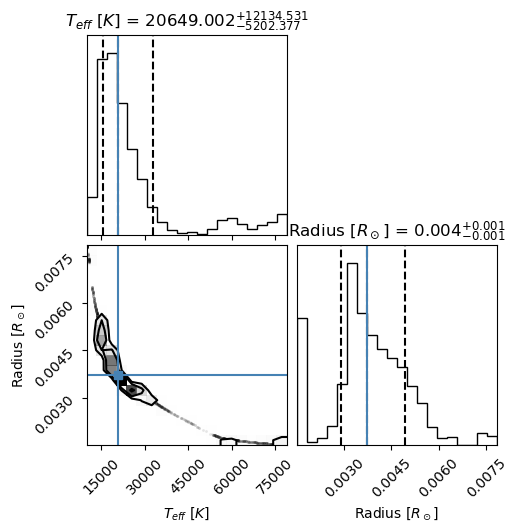

In [8]:
labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
best_est = np.zeros((len(labels)))
unc = []

for i in range(len(labels)):
    mcmc = np.percentile(flat_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(flat_chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

In [9]:
targets[['wd_source_id', 'cmd_radius']]

wd_source_id,cmd_radius
int64,float64
321259125631010688,0.00607263759050093
2153552814748001792,0.006786168093090157
2376773024012888832,0.0073973859146476235
3970162318385391488,0.006827360016277533
4248619071266347648,0.00695344430453521
4762592584885748608,0.006021104812980846
5309155039065680512,0.0066949591006259844
5750618956285716480,0.0072459406314183674
5924037812888396544,0.003943364705014442
